In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [13]:
file_path = '/home/tourmii/Documents/Projects/football-market-prediction/data/cleaned_player_data.csv'
df = pd.read_csv(file_path)

In [14]:
df.columns.to_list()

['playerId',
 'name',
 'contractUntil',
 'teamId',
 'teamName',
 'date_of_birth',
 'age',
 'height',
 'preferredFoot',
 'position',
 'firstSidePosition',
 'secondSidePosition',
 'nationalityId',
 'MarketValueCurrent',
 'preferredFootId',
 'positionId',
 'firstSidePositionId',
 'secondSidePositionId',
 'MarketValuePrevious',
 'MarketValueCurrency',
 'player_name',
 'rating',
 'totalRating',
 'countRating',
 'goals',
 'bigChancesCreated',
 'bigChancesMissed',
 'assists',
 'expectedAssists',
 'goalsAssistsSum',
 'accuratePasses',
 'inaccuratePasses',
 'totalPasses',
 'accuratePassesPercentage',
 'accurateOwnHalfPasses',
 'accurateOppositionHalfPasses',
 'accurateFinalThirdPasses',
 'keyPasses',
 'successfulDribbles',
 'successfulDribblesPercentage',
 'tackles',
 'interceptions',
 'yellowCards',
 'directRedCards',
 'redCards',
 'accurateCrosses',
 'accurateCrossesPercentage',
 'totalShots',
 'shotsOnTarget',
 'shotsOffTarget',
 'groundDuelsWon',
 'groundDuelsWonPercentage',
 'aerialDuelsWo

In [15]:
from column_groups import (
    COLUMN_GROUPS, 
    OUTFIELD_FEATURES,  
    GK_FEATURES, 
    get_columns_by_group 
)

In [21]:
groups = list(COLUMN_GROUPS.keys())
print(groups)

['identifiers_metadata', 'contract_market', 'demographics_physical', 'position_role', 'playing_time', 'rating_performance', 'attacking_output', 'chance_creation', 'passing_buildup', 'dribbling_carrying', 'defensive_actions', 'duels_physical', 'discipline_fouls', 'errors_mistakes', 'set_pieces_penalties', 'goalkeeping']


# EDA By Groups

## 1. Demographics

In [ ]:
phys_cols = get_columns_by_group("demographics_physical")
print(f"Demographics & Physical columns: {phys_cols}")

Demographics & Physical columns: ['date_of_birth', 'age', 'height', 'preferredFoot', 'preferredFootId']


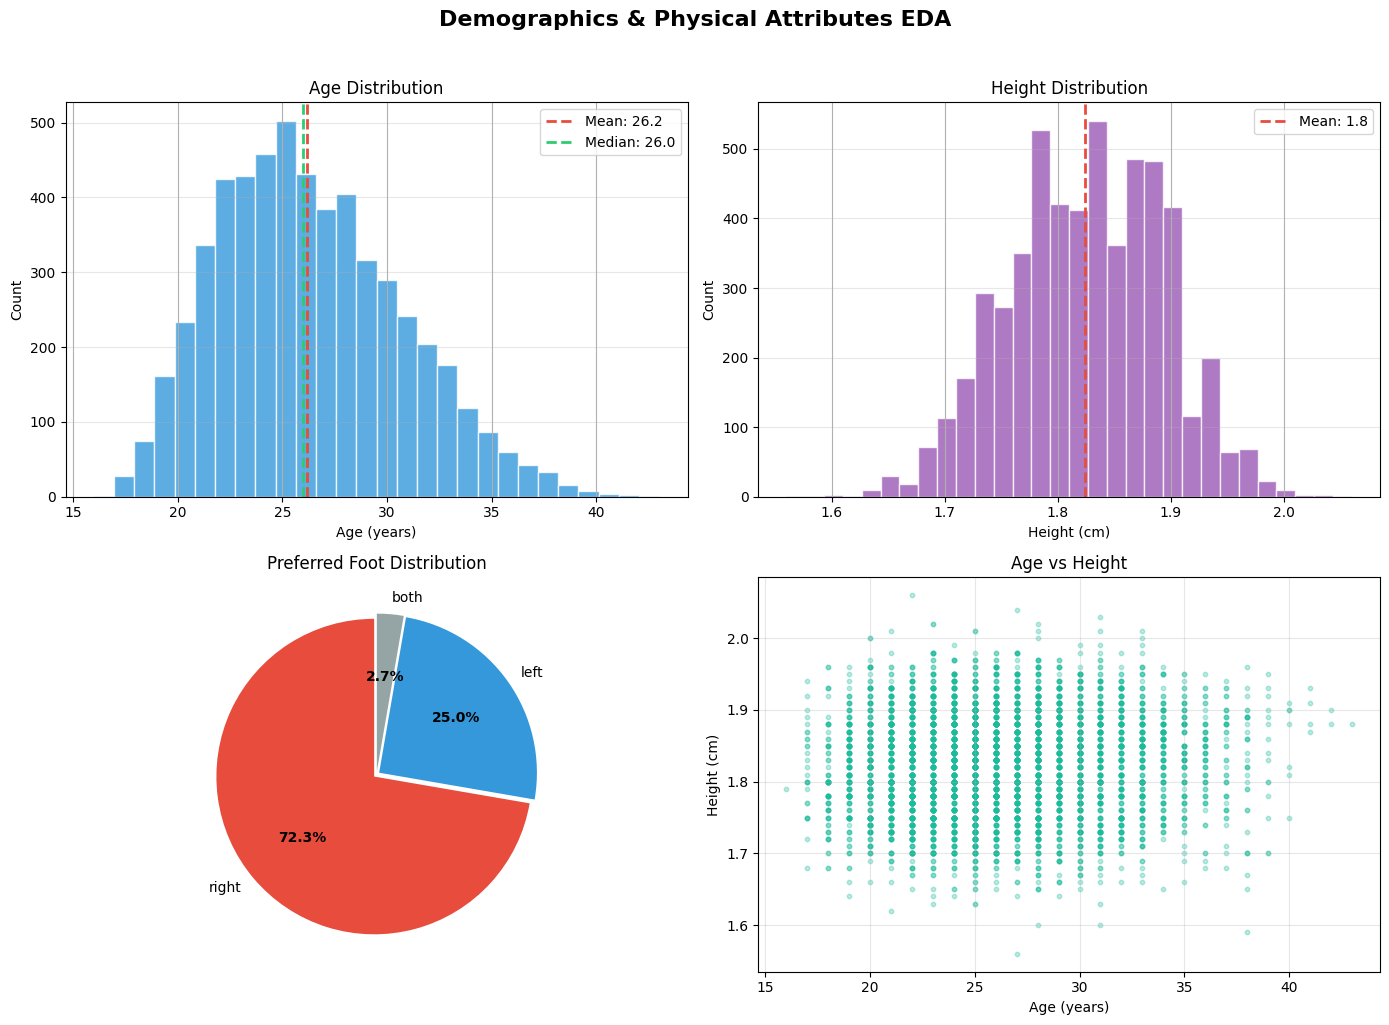

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Demographics & Physical Attributes EDA', fontsize=16, fontweight='bold', y=1.02)
fig.patch.set_facecolor('white')

ax1 = axes[0, 0]
if 'age' in df.columns:
    df['age'].hist(bins=28, ax=ax1, color='#3498db', edgecolor='white', alpha=0.8)
    ax1.axvline(df['age'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['age'].mean():.1f}")
    ax1.axvline(df['age'].median(), color='#2ecc71', linestyle='--', lw=2, label=f"Median: {df['age'].median():.1f}")
    ax1.set_xlabel('Age (years)')
    ax1.set_ylabel('Count')
    ax1.set_title('Age Distribution')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
if 'height' in df.columns:
    df['height'].hist(bins=30, ax=ax2, color='#9b59b6', edgecolor='white', alpha=0.8)
    ax2.axvline(df['height'].mean(), color='#e74c3c', linestyle='--', lw=2, label=f"Mean: {df['height'].mean():.1f}")
    ax2.set_xlabel('Height (cm)')
    ax2.set_ylabel('Count')
    ax2.set_title('Height Distribution')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
if 'preferredFoot' in df.columns:
    foot_counts = df['preferredFoot'].value_counts()
    colors = ['#e74c3c', '#3498db', '#95a5a6'][:len(foot_counts)]
    
    wedges, texts, autotexts = ax3.pie(
        foot_counts, 
        labels=foot_counts.index,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.02] * len(foot_counts),
    )
    
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('black')
    
    ax3.set_title('Preferred Foot Distribution')
ax4 = axes[1, 1]
if 'age' in df.columns and 'height' in df.columns:
    ax4.scatter(df['age'], df['height'], alpha=0.3, c='#1abc9c', s=10)
    ax4.set_xlabel('Age (years)')
    ax4.set_ylabel('Height (cm)')
    ax4.set_title('Age vs Height')
    ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Contract Market

In [51]:
value = get_columns_by_group("contract_market")
print(f"Contract Market columns: {value}")

Contract Market columns: ['contractUntil', 'MarketValueCurrent', 'MarketValuePrevious', 'MarketValueCurrency']


In [52]:
df['delta_price'] = df['MarketValueCurrent'] - df['MarketValuePrevious']


Delta Price Summary Statistics
Count:              5,466
Mean:           12,036.22
Median:              0.00
Std Dev:     2,362,027.46
Min:       -20,000,000.00
Max:        30,000,000.00


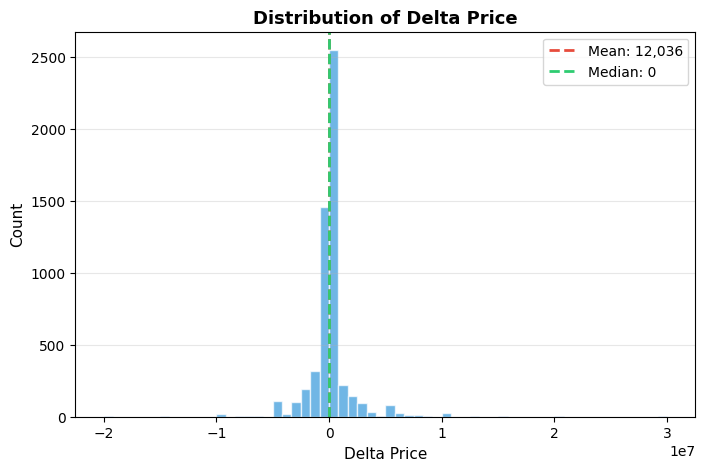

In [57]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('white')

data = df['delta_price'].dropna()
ax.hist(data, bins=60, color='#3498db', edgecolor='white', alpha=0.7)
ax.set_xlabel('Delta Price', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of Delta Price', fontsize=13, fontweight='bold')
ax.axvline(data.mean(), color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {data.mean():,.0f}')
ax.axvline(data.median(), color='#2ecc71', linestyle='--', linewidth=2, label=f'Median: {data.median():,.0f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

print(f"\n{'='*40}")
print(f"Delta Price Summary Statistics")
print(f"{'='*40}")
print(f"Count:    {len(data):>15,}")
print(f"Mean:     {data.mean():>15,.2f}")
print(f"Median:   {data.median():>15,.2f}")
print(f"Std Dev:  {data.std():>15,.2f}")
print(f"Min:      {data.min():>15,.2f}")
print(f"Max:      {data.max():>15,.2f}")
print(f"{'='*40}")

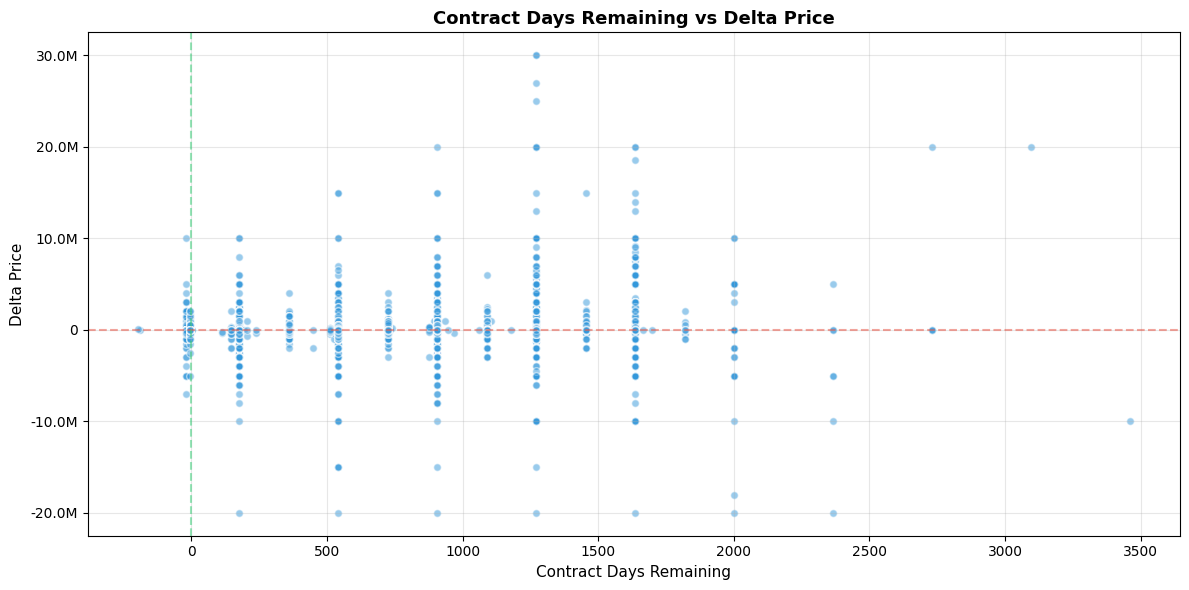

In [ ]:
from datetime import datetime
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize=(12, 6))

plot_df = df[['contractUntil', 'delta_price']].dropna().copy()
today = datetime.now()
plot_df['contract_days'] = (pd.to_datetime(plot_df['contractUntil'], format='mixed') - today).dt.days

ax.scatter(plot_df['contract_days'], plot_df['delta_price'], 
           alpha=0.5, color='#3498db', edgecolor='white', s=30)

def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

ax.yaxis.set_major_formatter(FuncFormatter(format_price))

ax.set_xlabel('Contract Days Remaining', fontsize=11)
ax.set_ylabel('Delta Price', fontsize=11)
ax.set_title('Contract Days Remaining vs Delta Price', fontsize=13, fontweight='bold')
ax.axhline(0, color='#e74c3c', linestyle='--', alpha=0.5)
ax.axvline(0, color='#2ecc71', linestyle='--', alpha=0.5)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Position Role

In [66]:
pos_cols = get_columns_by_group("position_role")
print(f"Position columns: {pos_cols}")

Position columns: ['position', 'positionId', 'firstSidePosition', 'firstSidePositionId', 'secondSidePosition', 'secondSidePositionId']


In [88]:
def get_hybrid_type(position, first, second, role_map):
    roles = {position, first, second}
    groups = {role_map[r] for r in roles if r in role_map}

    if groups == {"GK"}:
        return "goalkeeper"

    if len(groups) == 1:
        return "non_hybrid"

    if groups == {"DEF", "MID"}:
        return "defensive_hybrid"

    if groups == {"MID", "ATT"}:
        return "attacking_hybrid"

    if groups == {"DEF", "ATT"}:
        return "extreme_hybrid"

    if groups == {"DEF", "MID", "ATT"}:
        return "full_hybrid"

    return "unknown"

In [99]:
from role_map import ROLE_GROUP_MAP

df['hybrid_type'] = df.apply(
    lambda row: get_hybrid_type(
        row['position'], 
        row['firstSidePosition'], 
        row['secondSidePosition'], 
        ROLE_GROUP_MAP
    ), axis=1
)

/tmp/ipykernel_11090/2189586617.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(plot_data, labels=plot_labels, patch_artist=True)


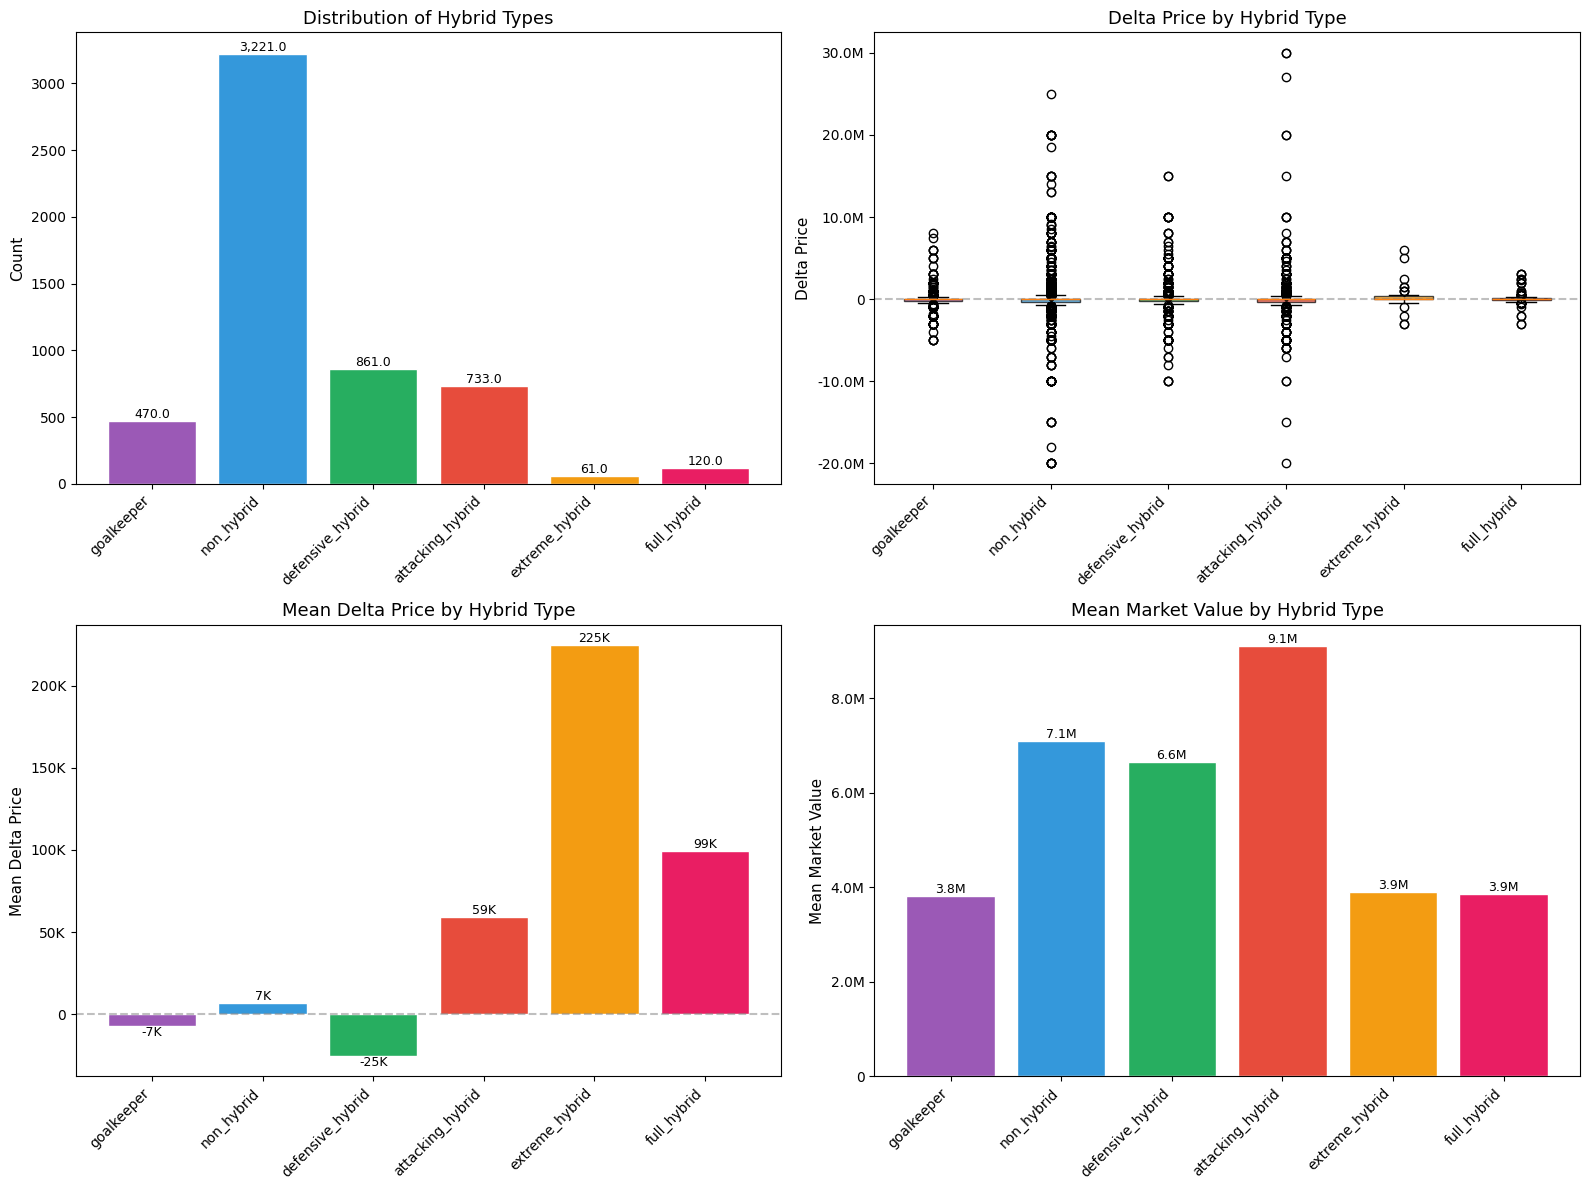

In [98]:
def format_price(x, pos):
    if abs(x) >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif abs(x) >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{x:.0f}'

hybrid_order = ['goalkeeper', 'non_hybrid', 'defensive_hybrid', 'attacking_hybrid', 'extreme_hybrid', 'full_hybrid', 'unknown']
colors = ['#9b59b6', '#3498db', '#27ae60', '#e74c3c', '#f39c12', '#e91e63', '#95a5a6']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Count by hybrid type
ax1 = axes[0, 0]
type_counts = df['hybrid_type'].value_counts().reindex(hybrid_order).dropna()
bars = ax1.bar(range(len(type_counts)), type_counts.values, color=colors[:len(type_counts)], edgecolor='white')
ax1.set_xticks(range(len(type_counts)))
ax1.set_xticklabels(type_counts.index, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Distribution of Hybrid Types', fontsize=13)
for bar, val in zip(bars, type_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:,}', 
             ha='center', va='bottom', fontsize=9)

# 2. Delta Price by hybrid type (box plot)
ax2 = axes[0, 1]
plot_data = [df[df['hybrid_type'] == t]['delta_price'].dropna() for t in hybrid_order if t in df['hybrid_type'].values]
plot_labels = [t for t in hybrid_order if t in df['hybrid_type'].values]
bp = ax2.boxplot(plot_data, labels=plot_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_xticklabels(plot_labels, rotation=45, ha='right')
ax2.set_ylabel('Delta Price', fontsize=11)
ax2.set_title('Delta Price by Hybrid Type', fontsize=13)
ax2.yaxis.set_major_formatter(FuncFormatter(format_price))
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)

# 3. Mean Delta Price by hybrid type
ax3 = axes[1, 0]
mean_delta = df.groupby('hybrid_type')['delta_price'].mean().reindex(hybrid_order).dropna()
bars = ax3.bar(range(len(mean_delta)), mean_delta.values, color=colors[:len(mean_delta)], edgecolor='white')
ax3.set_xticks(range(len(mean_delta)))
ax3.set_xticklabels(mean_delta.index, rotation=45, ha='right')
ax3.set_ylabel('Mean Delta Price', fontsize=11)
ax3.set_title('Mean Delta Price by Hybrid Type', fontsize=13)
ax3.yaxis.set_major_formatter(FuncFormatter(format_price))
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars, mean_delta.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val/1000:.0f}K', 
             ha='center', va='bottom' if val >= 0 else 'top', fontsize=9)

# 4. Market Value by hybrid type (if available)
ax4 = axes[1, 1]
if 'MarketValueCurrent' in df.columns:
    mean_mv = df.groupby('hybrid_type')['MarketValueCurrent'].mean().reindex(hybrid_order).dropna()
    bars = ax4.bar(range(len(mean_mv)), mean_mv.values, color=colors[:len(mean_mv)], edgecolor='white')
    ax4.set_xticks(range(len(mean_mv)))
    ax4.set_xticklabels(mean_mv.index, rotation=45, ha='right')
    ax4.set_ylabel('Mean Market Value', fontsize=11)
    ax4.set_title('Mean Market Value by Hybrid Type', fontsize=13)
    ax4.yaxis.set_major_formatter(FuncFormatter(format_price))
    
    for bar, val in zip(bars, mean_mv.values):
        if val >= 1_000_000:
            label = f'{val/1_000_000:.1f}M'
        elif val >= 1_000:
            label = f'{val/1_000:.0f}K'
        else:
            label = f'{val:.0f}'
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), label, 
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Playing Time

In [103]:
time_cols = get_columns_by_group('playing_time')
df[['totwAppearances', 'name']]

,totwAppearances,name
0,7.0,Joan García
1,0.0,Marc-André ter Stegen
2,0.0,Wojciech Szczesny
3,2.0,Pau Cubarsí
4,0.0,Eric García
...,...,...
5461,1.0,Hudson
5462,0.0,Mandaca
5463,0.0,Rafinha
5464,0.0,Gabriel Veron
